In [1]:
import torch
import xmltodict
import numpy as np
import utils as ut
import pandas as pd
from skimage import io as skio
from matplotlib import patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from torchvision import transforms as T
from sklearn.metrics import roc_auc_score, recall_score, average_precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve, precision_recall_curve
device = torch.device("cpu")

def print_confusion_matrix(folder, model_name):
    df = pd.read_csv(f"{folder}{model_name}_test_stats_seed_0.csv", index_col=False)
    yte = df.y.values
    yhatte = df.yhat.values
    print(confusion_matrix(yte, yhatte))

def print_metrics_of_all_models(folder):
    models = ["densenet", "resnet", "shufflenet", "mnasnet", "efficientnet", "vgg", "mobilenet",]
    df = pd.DataFrame(index=models)
    for model_name in models:
        dfin = pd.read_csv(f"{folder}{model_name}_test_stats_seed_0.csv", index_col=False)
        yte = dfin.y.values
        yhatte = dfin.yhat.values
        scorete1 = dfin.score1.values  
        df.loc[model_name, 'auc'] = roc_auc_score(yte, scorete1)
        df.loc[model_name, 'acc'] = accuracy_score(yte, yhatte)
        df.loc[model_name, 'f1'] = f1_score(yte, yhatte)
        df.loc[model_name, 'pre'] = precision_score(yte, yhatte)
        df.loc[model_name, 'rec'] = recall_score(yte, yhatte)
    print(df)

def get_roc(folder, model_name):
    df = pd.read_csv(f"{folder}{model_name}_test_stats_seed_0.csv", index_col=False)
    yte = df.y.values
    scorete1 = df.score1.values  

    fpr, tpr, thr_roc = roc_curve(yte, scorete1)
    p, r, thr_pr = precision_recall_curve(yte, scorete1)
    aps = average_precision_score(yte, scorete1)
    auc = roc_auc_score(yte, scorete1)
    return fpr, tpr, thr_roc, p, r, thr_pr, aps, auc

def plot_roc_and_prc_of_all_models(folder):
    fr, tr, _, pr, rr, _, apsr, aucr = get_roc(folder, 'resnet')
    fd, td, _, pd, rd, _, apsd, aucd = get_roc(folder, 'densenet')
    fm, tm, _, pm, rm, _, apsm, aucm = get_roc(folder, 'mobilenet')
    fe, te, _, pe, re, _, apse, auce = get_roc(folder, 'efficientnet')
    fs, ts, _, ps, rs, _, apss, aucs = get_roc(folder, 'shufflenet')
    fv, tv, _, pv, rv, _, apsv, aucv = get_roc(folder, 'vgg')

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ident = [0.0, 1.0]
    ax.plot(fm, tm)
    ax.plot(fd, td)
    ax.plot(fr, tr)
    ax.plot(fe, te)
    ax.plot(fs, ts)
    ax.plot(fv, tv)
    ax.plot(ident,ident, '--')
    ax.set_xlabel("False positive rate", fontsize=16)
    ax.set_ylabel("True positive rate", fontsize=16)
    ax.legend(["Mobilenet (0.9259)",
               "Densenet (0.9358)", 
               "Resnet (0.8592)",         
               "Efficientnet (0.9147)",               
               "Shufflenet (0.9023)"], 
               "VGG (0.9042)",
               fontsize=12)
    # fig.show()
    # plt.savefig('results/roc_curve.png', transparent=False, facecolor='white')

    fig1, ax1 = plt.subplots(1, figsize=(8, 6))
    ax1.plot(pm, rm)
    ax1.plot(pd, rd)
    ax1.plot(pr, rr)
    ax1.plot(pe, re)
    ax1.plot(ps, rs)
    ax1.plot(pv, rv)
    ax1.set_xlabel("Recall", fontsize=16)
    ax1.set_ylabel("Precision", fontsize=16)
    ax1.legend(["Mobilenet (0.83694)",
                "Densenet (0.84407)", 
                "Resnet (0.84489)",
                "Efficientnet (0.78905)",            
                "VGG (0.77351)",
                "Shufflenet (0.67312)", ], fontsize=12)
    # fig1.show()
    # plt.savefig('results/prc_curve.png', transparent=False, facecolor='white')            


# 10m files test files: WENR_ortho_Rumex_10m_1_nw, WENR_ortho_Rumex_10m_4_se
# 15m test file 'WENR_ortho_Rumex_15m_2_sw'

def overlay_true_and_predicted_bbox(model_name, 
                                    folder, 
                                    ortho_image_file, 
                                    xml_ground_truth_file):
    ps = 256
    root = et.parse(xml_ground_truth_file).getroot()
    xmlstr = et.tostring(root, encoding='utf-8', method='xml')
    xmldict = dict(xmltodict.parse(xmlstr))

    im_size = xmldict['annotation']['size']
    im_height = int(im_size['height'])
    im_width = int(im_size['width'])
    im_depth = int(im_size['depth'])

    # load image and resize it to be multiple of ps
    npatches_w = im_width // ps
    npatches_h = im_height // ps
    im = skio.imread(ortho_image_file)

    im = im[:npatches_h * ps, :npatches_w * ps, :]
    im_label = np.zeros(im.shape[:2])
    true_bbox = []

    # get annotations form xml file and create true bbox list 
    objects = xmldict['annotation']['object']
    nobjects = len(objects)
    for i in range(nobjects):
        obj_i = objects[i]
        if obj_i['name'] == 'rumex':
            temp = obj_i['bndbox']
            bbox = [temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax']]
            bbox = [int(x) for x in bbox]

            xmin_r = bbox[0] // ps
            ymin_r = bbox[1] // ps
            xmax_r = bbox[2] // ps
            ymax_r = bbox[3] // ps

            if (xmax_r < npatches_w) & (ymax_r < npatches_h):
                if xmax_r - xmin_r >= 1:
                    x_patches_with_rumex = list(np.arange(xmin_r, xmax_r + 1))
                else:
                    x_patches_with_rumex = [xmin_r]

                if ymax_r - ymin_r >= 1:
                    y_patches_with_rumex = list(np.arange(ymin_r, ymax_r + 1))
                else:
                    y_patches_with_rumex = [ymin_r]

                for col in x_patches_with_rumex:
                    for row in y_patches_with_rumex:
    #                     label_patches[row, col] = 1
                        xmin = col*ps
                        xmax = xmin+ps
                        
                        ymin = row*ps
                        ymax = ymin+ps
                        
                        im_label[ymin:ymax, xmin:xmax]=1
                        true_bbox.append([xmin, ymin, xmax, ymax])
    

    # load a trained model
    model = ut.RumexNet(model_name)
    model.load_state_dict(torch.load(f"{folder}/{model_name}_state_dict_seed_0.pt", map_location=device))
    model.eval()

    # apply model to orthomosaic    
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]    
    tfms = T.Compose([T.ToPILImage(),T.Resize(224),T.ToTensor(), T.Normalize(imagenet_mean, imagenet_std)])
    pred_im_label = np.zeros(im.shape[:2])
    pred_bbox = []
    with torch.no_grad():
        for row in np.arange(npatches_h):
            for col in np.arange(npatches_w):
                ymin = row*ps
                ymax = (row + 1)*ps

                xmin = col*ps
                xmax = (col+1)*ps

                patch = im[ymin:ymax, xmin:xmax, :]
                patch_rgb = patch[:, :, :3]
                patch_mask = patch[:, :, -1]

                # 255 indicate inside the fild
                # if entire patch is inside the field then
                if np.sum(patch_mask == 255) == np.prod(patch_mask.shape):
                    x = tfms(patch_rgb)
                    x = x.unsqueeze(dim=0)
                    x = x.to(device)
                    score = model(x)  # logits
                    _, yhat = torch.max(score, 1)
                    # print(yhat.item(), end=",")
                    pred_im_label[ymin:ymax, xmin:xmax] = yhat.item()
                    if yhat.item() == 1:
                        pred_bbox.append([xmin, ymin, xmax, ymax])
    
    # overlay true and predicted bbox on the orthophoto
    fig, ax = plt.subplots(1,1, figsize=(60, 30))
    ax.imshow(im)
    plt.axis('off')
    # ax.set_cmap('gray')

    for bbox in true_bbox:
        ax.add_patch(patches.Rectangle((bbox[0],bbox[1]), ps, ps, fill=False, color='k', linewidth=3))

    for bbox in pred_bbox:
        ax.add_patch(patches.Rectangle((bbox[0],bbox[1]), ps, ps, fill=True, color='b', alpha=0.2))

    # fig.savefig(base_filename+'_with_true_bbox_overlay.png', 
    #             dpi=100, 
    #             bbox_inches='tight', 
    #             transparent=False, 
    #             facecolor='white')



# Print metrics

In [ ]:
print_metrics_of_all_models(folder = "results/10m/")

# Plot ROC curve (Figure 4 plots)

In [ ]:
plot_roc_and_prc_of_all_models(folder="results/10m/")

# Process an orthophoto and overlay true and predicted bbox

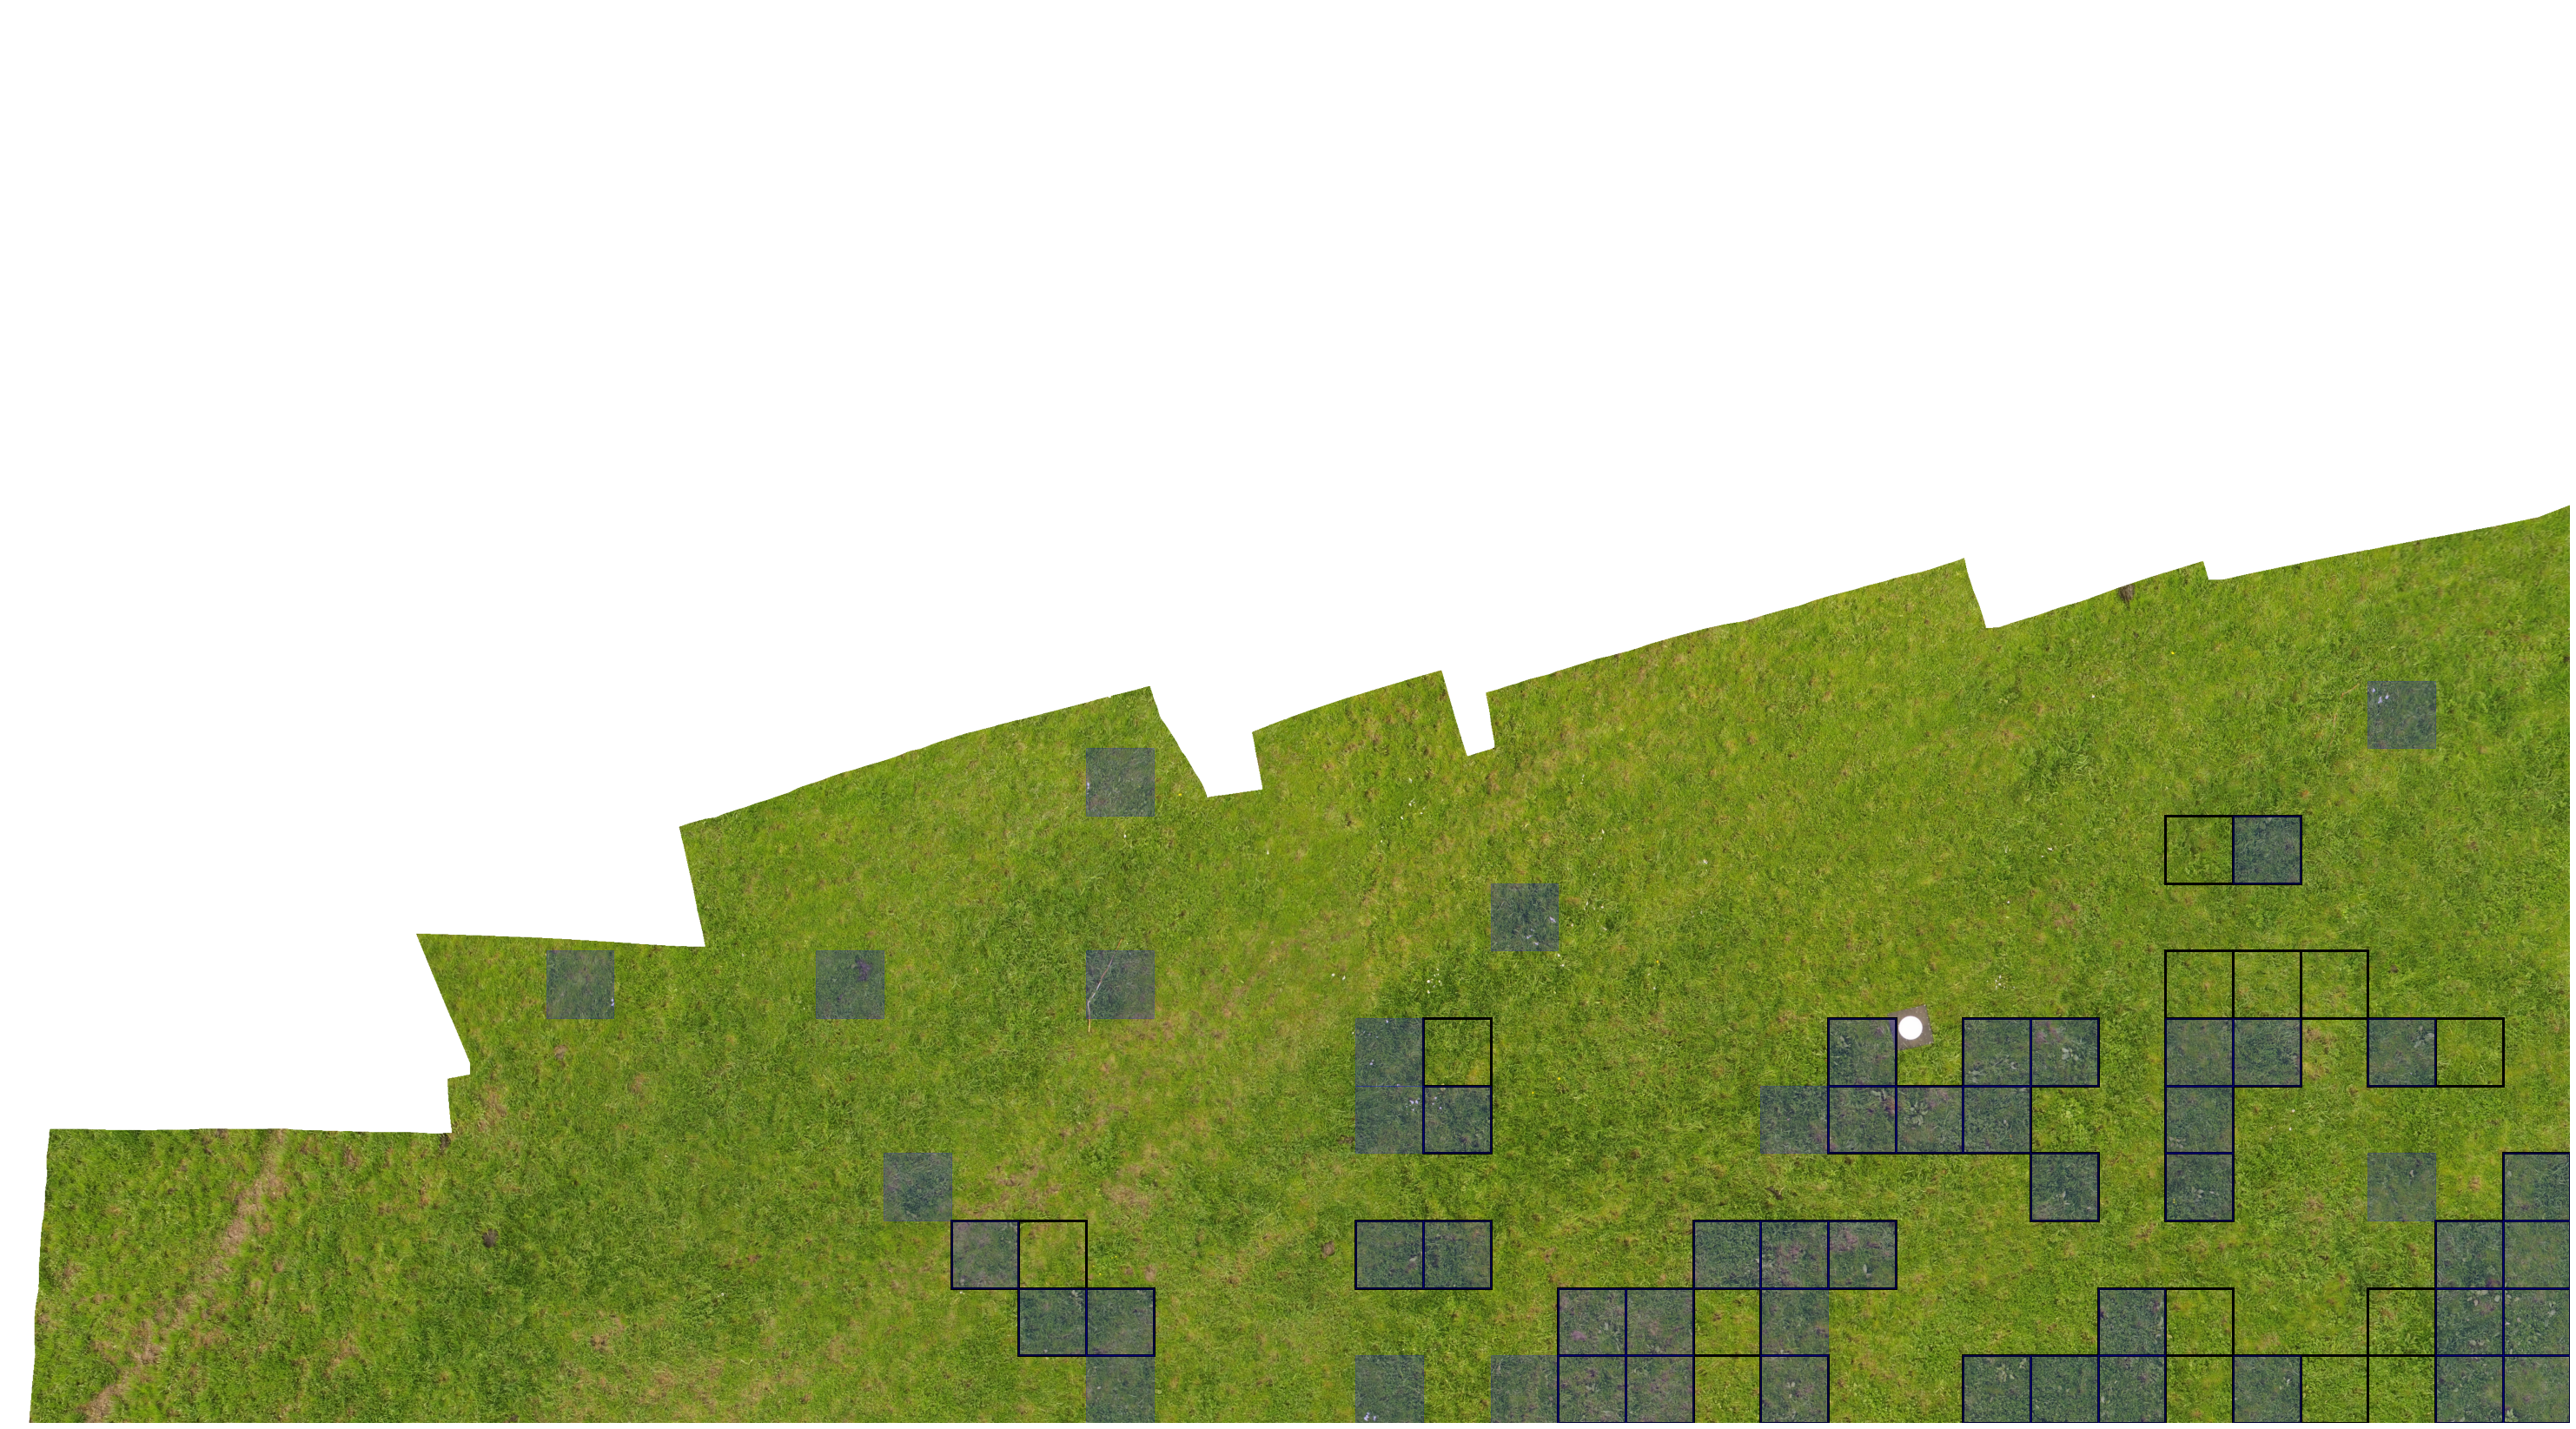

In [2]:
overlay_true_and_predicted_bbox(model_name="mobilenet", folder = "results/10m/",
                                ortho_image_file="data/ortho/WENR_ortho_Rumex_10m_1_nw.png", 
                                xml_ground_truth_file="data/ortho/WENR_ortho_Rumex_10m_1_nw.xml")

# Test Mobilenet-10 on 15m data

In [3]:
model = ut.RumexNet("mobilenet")
model.load_state_dict(torch.load(f"results/15m/15m_mobilenet_retrained_state_dict_seed_0.pt", map_location=device))
model.eval()

# test dataset and data loader
dste = ut.RumexDataset("data/15m/test/")
dlte = ut.test_loader(dste, 64)

losste, metrics = ut.test(model, dlte, device)
print(metrics)


FileNotFoundError: [Errno 2] No such file or directory: 'results/15m/15m_mobilenet_retrained__state_dict_seed_0.pt'